# Data Exploration

First, the training data is imported and an overall description is provided.  This will give us a high level view of the data, including its span and variance.  The testing dataset is also imported at this stage, but will be held until the models used are tested.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import warnings
import math
import numpy as np
from numpy.random import random
from scipy.spatial import distance
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score,  precision_score, recall_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

from imblearn.over_sampling import SMOTE

%matplotlib inline
warnings.filterwarnings('ignore')

df = pd.read_csv('/content/drive/MyDrive/CBC_3200.csv')
raw_test_set = pd.read_csv('/content/drive/MyDrive/CBC_800.csv')

# Edit column name for easier reading
df.rename(columns = {'M':'TotalMoney'}, inplace = True)
df.rename(columns = {'R':'M_LastPurchase'}, inplace = True)
df.rename(columns = {'F':'Freq'}, inplace = True)

df.head()

,Seq#,ID#,Gender,TotalMoney,M_LastPurchase,Freq,FirstPurch,ChildBks,YouthBks,CookBks,DoItYBks,RefBks,ArtBks,GeogBks,ItalCook,ItalAtlas,ItalArt,Florence
0,1712,14148,0,218,2,2,4,0,0,0,0,0,0,0,0,0,0,1
1,3042,25193,1,217,6,1,6,0,0,0,0,0,0,0,0,0,0,0
2,204,1784,1,32,12,1,12,0,0,0,0,0,0,0,0,0,0,0
3,3628,30102,0,199,8,2,10,0,0,0,0,0,1,2,0,0,0,0
4,444,3989,1,203,16,2,24,1,0,1,0,0,0,0,1,0,0,0


The attributes: 'Seq#', "ID#', and 'Gender' are all nominal types as they only show distinction. 'Gender' is binarized with 0=Male and 1=Female. The remaining attributes are ratio types as a value of 0 has an important meaning.  For example, if a customer has a value of 0 for 'ArtBks', this means that they purchased zero books from the art book section-this could influence their probability of purchasing *The Art History of Florence*. If 'M' or 'F' is 0, that equates to the customer spending $0 at the bookstore (or no purchases).  While a value of 0 for 'M' does not exist in this dataset since a customer had to purchase something to be in the database, I would argue that this attribute is ratio. Lastly, 'R' is ratio as this signifies the number of months since a last purchase, a value of 0 would equate to a purchase being the month the data was collected.

In [ ]:
#Describes the dataset
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Seq#,3200.0,2003.824375,1150.290162,1.0,1015.75,2019.5,2996.25,4000.0
ID#,3200.0,16621.452187,9446.798182,25.0,8387.25,16703.0,24799.50,32977.0
Gender,3200.0,0.703750,0.456674,0.0,0.00,1.0,1.00,1.0
TotalMoney,3200.0,208.002813,100.440485,15.0,128.00,208.0,284.00,475.0
M_LastPurchase,3200.0,13.431875,8.085878,2.0,8.00,12.0,16.00,36.0
Freq,3200.0,3.780000,3.440065,1.0,1.00,2.0,6.00,12.0
FirstPurch,3200.0,26.277188,18.152209,2.0,12.00,20.0,36.00,99.0
ChildBks,3200.0,0.627188,0.994866,0.0,0.00,0.0,1.00,7.0
YouthBks,3200.0,0.306875,0.617209,0.0,0.00,0.0,0.00,5.0
CookBks,3200.0,0.724063,1.084914,0.0,0.00,0.0,1.00,7.0


In [ ]:
#Print the size of the dataset
print(df.shape)

(3200, 18)


The training set has 3200 objects (customers), 17 attributes and 1 class(Florence).  It is also observed that the value span are relatively close, with the exception of 'M', which represents the totalized dollar amount the customer spent at the bookstore. This is important in determining if normalization should be performed.  'Seq#' and 'ID#' will be discussed later. Next, we will print out the categorical barchart to show to distribution of values for each attribute.

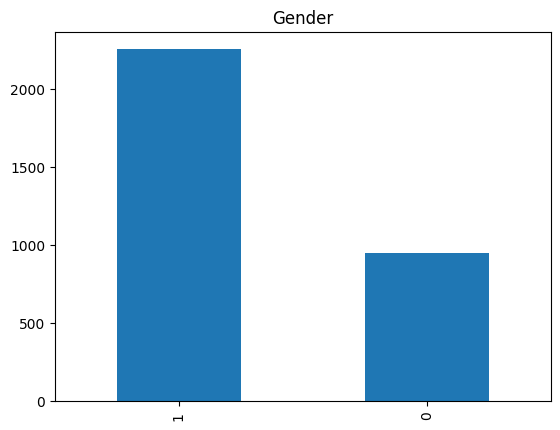

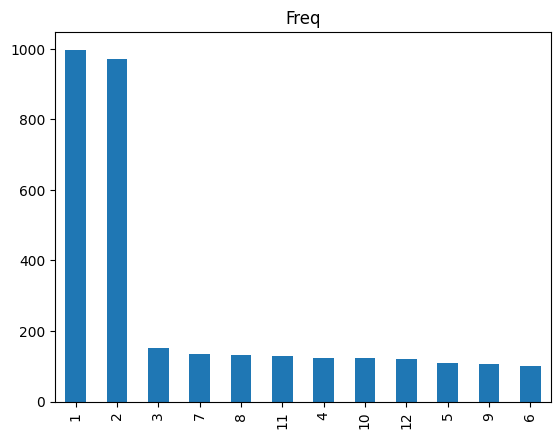

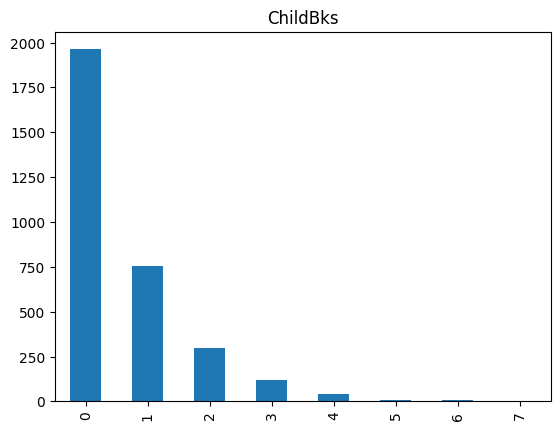

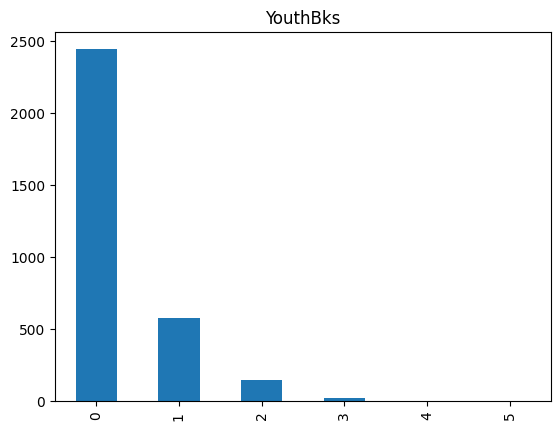

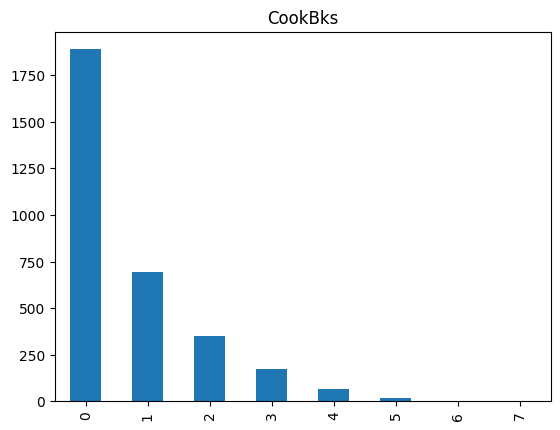

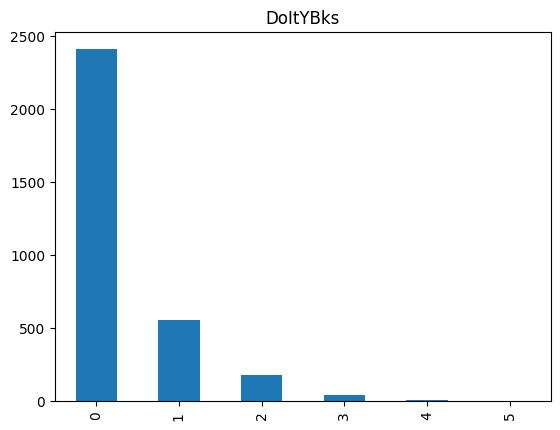

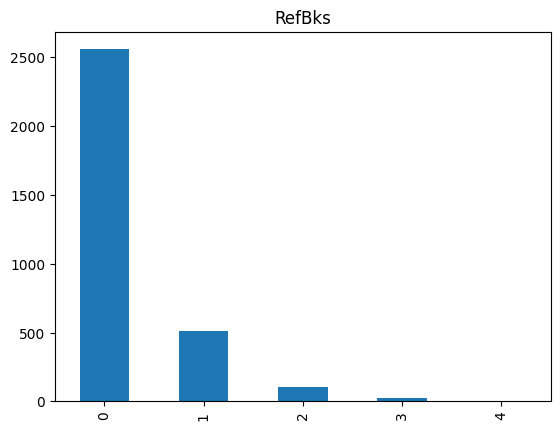

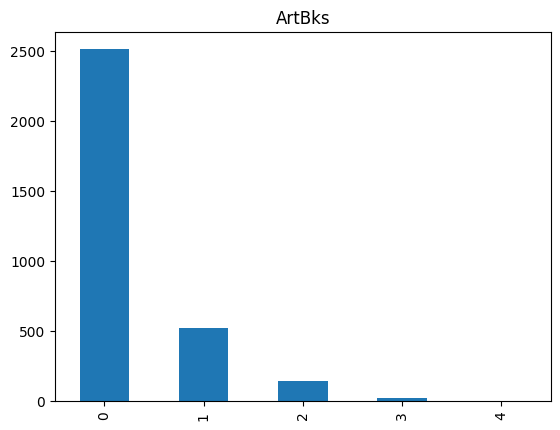

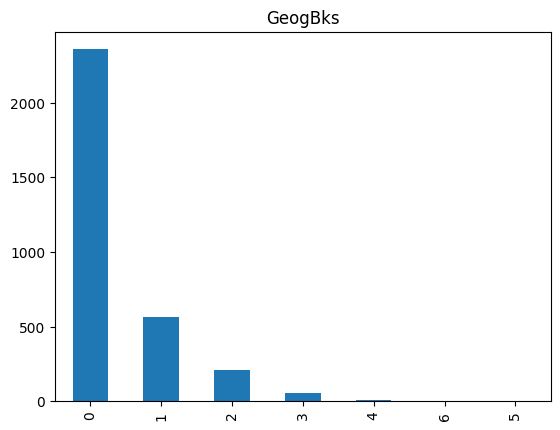

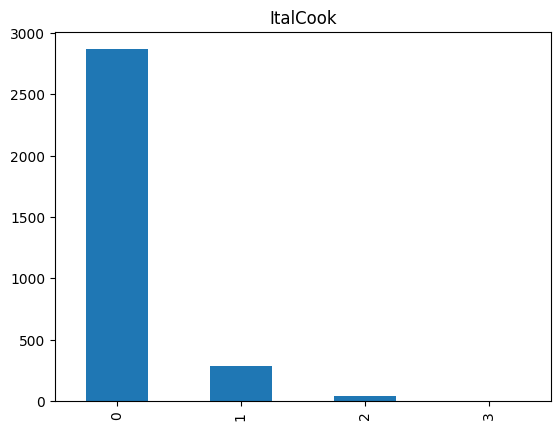

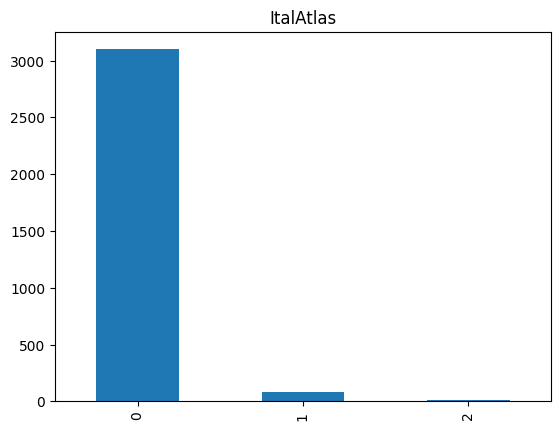

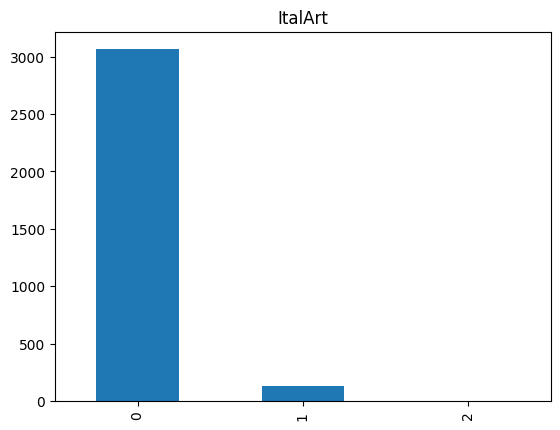

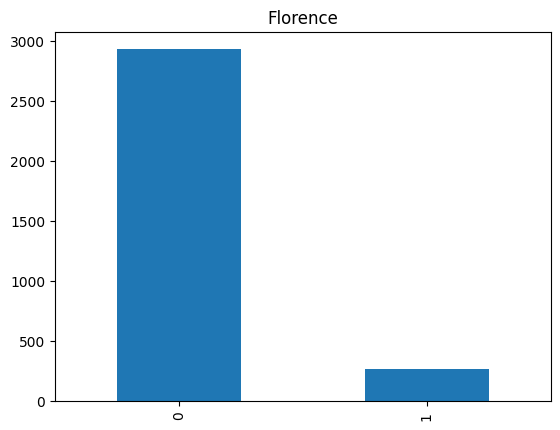

In [ ]:
# plot bar charts of each categorical variable
categorical_vars = ['Gender',	'Freq' ,'ChildBks',	'YouthBks',	'CookBks',	'DoItYBks',	'RefBks',	'ArtBks',	'GeogBks',	'ItalCook',	'ItalAtlas',	'ItalArt', 'Florence']
for var in categorical_vars:
    df[var].value_counts().plot(kind='bar')
    plt.title(var)
    plt.show()

In [ ]:
Counter(df.Florence)

Counter({1: 270, 0: 2930})

We can see the class 'Florence' is highly inbalanced as only 270 customers bought the 'Florence' book out of 3200 total.  The dataset is of a non normal distribution. This will be addressed later. We carried out a bar chart analysis to get an idea of the number of books purchased in each category.  We decided to perform a correlation matrix to identify possible linear correlations.   

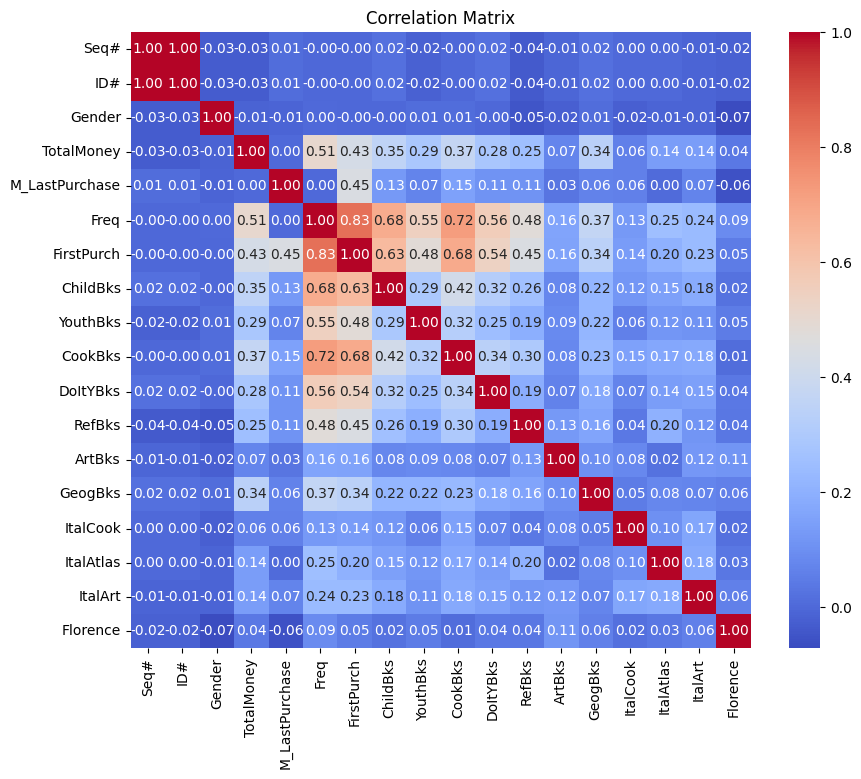

In [ ]:
# Compute the correlation matrix
correlation_matrix = df.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

We expected to see Florence and Art Books strongly correlated, however they only had a correlation of 0.11.  Secondly the customers that purchased more frequently had a higher (but still low at 0.08) correlation of purchasing Florence. Of the attributes, 'FirstPurch' and 'Freq' were the highly correlatated with each other at 0.83.   Of the book catagories, 'Cook Books' and 'Children Books' had the highest correlation with frequent shoppers. Interestingly, the total amount of money spent at a store was most corrleated with 'Cook Books', 'Children Books' and 'Geography Books'.

Next, we will drop the unneeded colums ('Seq#' and 'ID#'). These are not value added as are identification numbers assigned to the customer in the dataset, or the entire customer database the bookstore has. There is no information on how these numbers are assigned, but they are assumed to be sequential in nature.  Since the 4000 customers were randomly selected, there should be no correlation between 'Seq#' and 'ID#' and which books are purchased

In [ ]:
df = df.drop(columns = ['Seq#', 'ID#'], axis=1)
df

,Gender,TotalMoney,M_LastPurchase,Freq,FirstPurch,ChildBks,YouthBks,CookBks,DoItYBks,RefBks,ArtBks,GeogBks,ItalCook,ItalAtlas,ItalArt,Florence
0,0,218,2,2,4,0,0,0,0,0,0,0,0,0,0,1
1,1,217,6,1,6,0,0,0,0,0,0,0,0,0,0,0
2,1,32,12,1,12,0,0,0,0,0,0,0,0,0,0,0
3,0,199,8,2,10,0,0,0,0,0,1,2,0,0,0,0
4,1,203,16,2,24,1,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,1,73,6,1,6,0,0,0,0,0,0,0,0,0,0,0
3196,0,240,14,2,20,0,0,1,0,0,0,0,0,0,0,1
3197,0,235,16,1,16,0,0,0,1,0,0,1,0,0,0,1
3198,0,118,8,2,16,0,0,1,0,0,0,0,0,0,0,0


Confirmed that 'Seq#' and 'ID#' have been removed.  A boxplot will be run lastly for data exploration.   'TotalMoney', 'M_LastPurchase', and 'FirstPurch' are an order of magnitude or more than the rest of the data, so we decided to normalize the data using the MinMaxScalar()

In [ ]:
scalar = MinMaxScaler()
df = pd.DataFrame(scalar.fit_transform(df), columns = ['Gender','TotalMoney','M_LastPurchase','Freq','FirstPurch','ChildBks','YouthBks','CookBks','DoItYBks','RefBks','ArtBks','GeogBks','ItalCook','ItalAtlas','ItalArt','Florence'])

<Axes: >

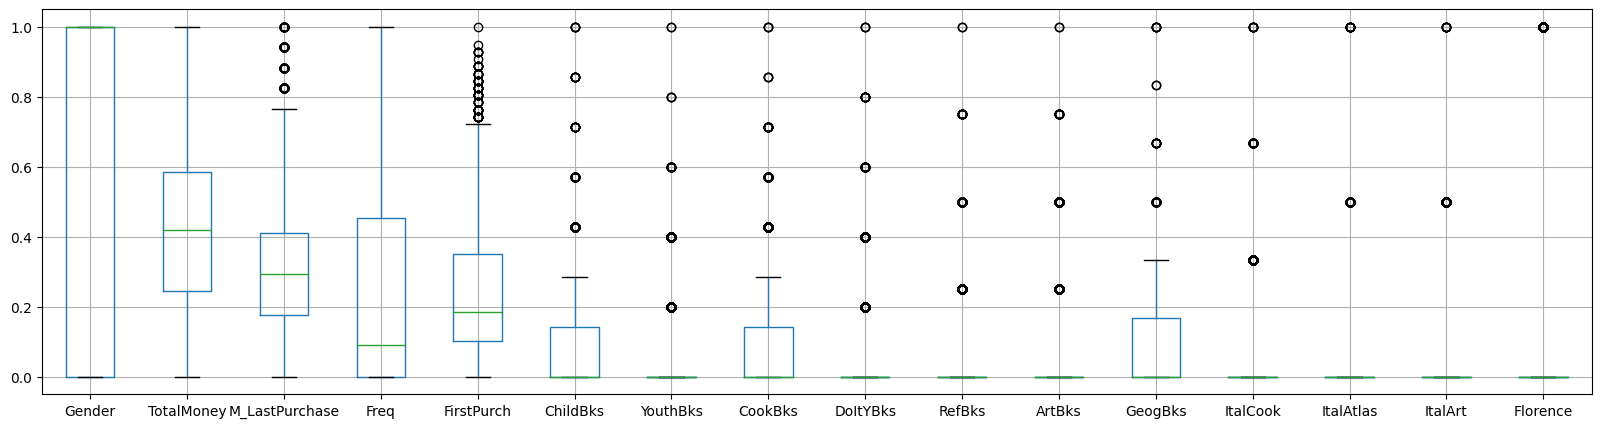

In [ ]:
df.boxplot(figsize=(20,5))

This boxplot shows possible outliers and the data is skewed. During preprocessing, we will analyze the data for potential outliers. Lastly, a final look at the processed training dataset is below:

In [ ]:
df

,Gender,TotalMoney,M_LastPurchase,Freq,FirstPurch,ChildBks,YouthBks,CookBks,DoItYBks,RefBks,ArtBks,GeogBks,ItalCook,ItalAtlas,ItalArt,Florence
0,0.0,0.441304,0.000000,0.090909,0.020619,0.000000,0.0,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.0,0.0,1.0
1,1.0,0.439130,0.117647,0.000000,0.041237,0.000000,0.0,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.0,0.0,0.0
2,1.0,0.036957,0.294118,0.000000,0.103093,0.000000,0.0,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.0,0.0,0.0
3,0.0,0.400000,0.176471,0.090909,0.082474,0.000000,0.0,0.000000,0.0,0.0,0.25,0.333333,0.000000,0.0,0.0,0.0
4,1.0,0.408696,0.411765,0.090909,0.226804,0.142857,0.0,0.142857,0.0,0.0,0.00,0.000000,0.333333,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,1.0,0.126087,0.117647,0.000000,0.041237,0.000000,0.0,0.000000,0.0,0.0,0.00,0.000000,0.000000,0.0,0.0,0.0
3196,0.0,0.489130,0.352941,0.090909,0.185567,0.000000,0.0,0.142857,0.0,0.0,0.00,0.000000,0.000000,0.0,0.0,1.0
3197,0.0,0.478261,0.411765,0.000000,0.144330,0.000000,0.0,0.000000,0.2,0.0,0.00,0.166667,0.000000,0.0,0.0,1.0
3198,0.0,0.223913,0.176471,0.090909,0.144330,0.000000,0.0,0.142857,0.0,0.0,0.00,0.000000,0.000000,0.0,0.0,0.0


# Preprocessing

In [ ]:
# Function to check if an element is an integer
def is_integer(value):
    return isinstance(value, int)

# Apply the function to each element in the DataFrame
result_df = df.applymap(is_integer)

# Display the result
print("DataFrame with Boolean values indicating if elements are integers:")
print(result_df)

DataFrame with Boolean values indicating if elements are integers:
      Gender  TotalMoney  M_LastPurchase   Freq  FirstPurch  ChildBks  \
0      False       False           False  False       False     False   
1      False       False           False  False       False     False   
2      False       False           False  False       False     False   
3      False       False           False  False       False     False   
4      False       False           False  False       False     False   
...      ...         ...             ...    ...         ...       ...   
3195   False       False           False  False       False     False   
3196   False       False           False  False       False     False   
3197   False       False           False  False       False     False   
3198   False       False           False  False       False     False   
3199   False       False           False  False       False     False   

      YouthBks  CookBks  DoItYBks  RefBks  ArtBks  GeogB

Next, we determined if there are any missing values.  Utilizing Pandas .isna() and .items(), we determined that there are no missing values in our dataset.

In [ ]:
#Loop function to check for missing values in the dataset
num_missing = 0
# iterate through column
for i in df:
    # check if any items are N/A or missing, using counter and true value
    for k in df[i].isna().items():
        if k[1]:
          num_missing += 1

print("Number of missing values: ", num_missing)



Number of missing values:  0


A density plot is printed below to determine the distribution of the data.  It is verified to be not normal.  Most data are of a Poisson distribution with exception of 'Gender' and 'Florence'-which are bimodal.  Models chosen to evaluate should perform well with non-normal distributed datasets.

<Axes: ylabel='Density'>

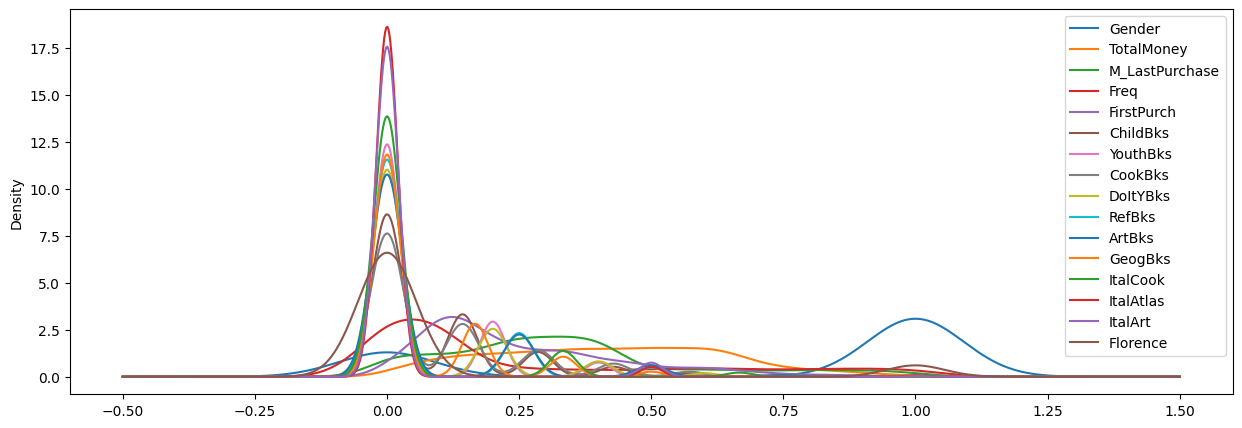

In [ ]:
df.plot(kind='density', figsize=(15,5))

Next, I will perform a K Nearest Neighbors anomoly detection to identify outliers (or anomolies).  I chose KNN since the data is not normally distributed. The number of neighbors chosen was $\sqrt{3200}$ or about $56$. The distances from each other were averaged and shown in the line plot below.  Any anomoly would stick out.

In [ ]:
knn = int(math.sqrt(3200))
nbrs = NearestNeighbors(n_neighbors=knn, metric=distance.euclidean).fit(df.values)
distances, indices = nbrs.kneighbors(df.values)
anomaly_score = distances[:,knn-1]

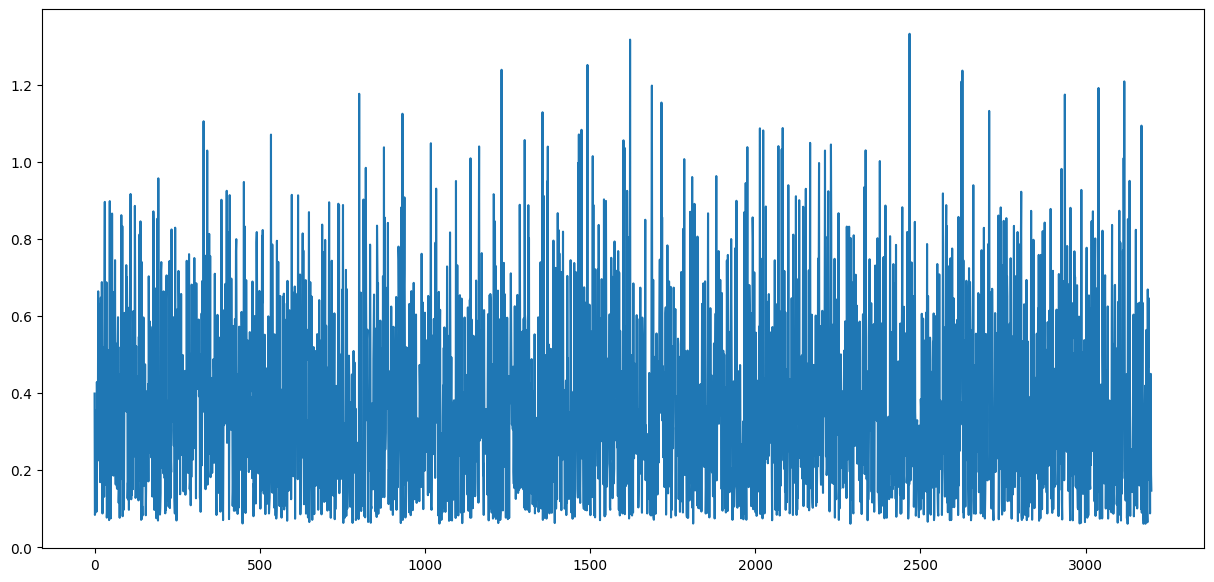

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(distances.mean(axis =1))

There are no obvious distances that stickout and signify an anomoly.  The statistical analysis was performed below.  

In [ ]:
dist_stats = pd.DataFrame(distances.mean(axis=1))
dist_stats.describe()

,0
count,3200.000000
mean,0.364685
std,0.230868
min,0.061011
25%,0.180136
50%,0.314431
75%,0.513573
max,1.333002


The statistical analysis of the mean distances indicate that the mean distance is 0.36 with a standard deviation of 0.23.  The max distance of 1.33 is a little over 5 standard deviations (1.288) above the mean.  I have decided to not remove any data for the following reasons: First there are no entry errors or false data as the numbers come from the sales transactions and are calculated by a computer.  Next, the data is normally distributed and applying the 3 standard deviation rule to this dataset will risk losing valuable data.

In [ ]:
#########################################
# Training and Validation set creation
#########################################

Y = df['Florence']
X = df.drop(['Florence'],axis=1)

from sklearn.model_selection import train_test_split
X_train, X_Validation, Y_train, Y_Validation = train_test_split(X, Y, test_size=0.8, random_state=1)

from sklearn import tree
from sklearn.metrics import accuracy_score
from collections import Counter

# import library for SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE()

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(X, Y)

print('Original dataset shape', Counter(Y))
print('Resample dataset shape', Counter(y_smote))

Original dataset shape Counter({0.0: 2930, 1.0: 270})
Resample dataset shape Counter({1.0: 2930, 0.0: 2930})


# Algorithms

### Logistic Regression

Accuracy: 0.91
Confusion Matrix:
 [[2331   14]
 [ 211    4]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.99      0.95      2345
         1.0       0.22      0.02      0.03       215

    accuracy                           0.91      2560
   macro avg       0.57      0.51      0.49      2560
weighted avg       0.86      0.91      0.88      2560



<Axes: >

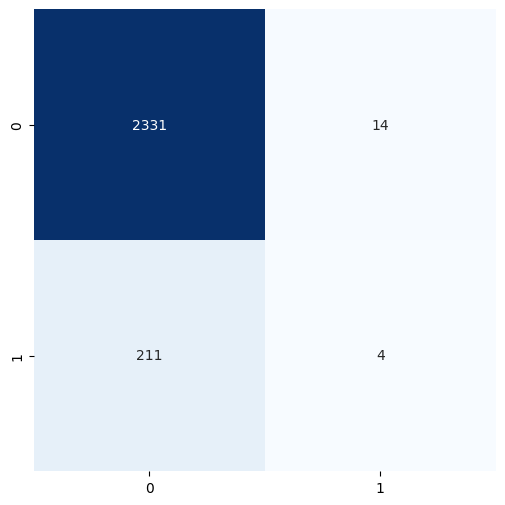

In [ ]:
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Split the data into features (X) and target variable (y)
X = df.drop(['Florence'],axis=1)
y = df['Florence']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=1)

# Standardize features (optional but can be beneficial for logistic regression)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create and train the logistic regression model
modellr = LogisticRegression(random_state=1)
modellr.fit(X_train, y_train)

# Make predictions on the test set
y_pred = modellr.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Display the results
print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_rep)

from sklearn.metrics import confusion_matrix
matrix_confusion = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

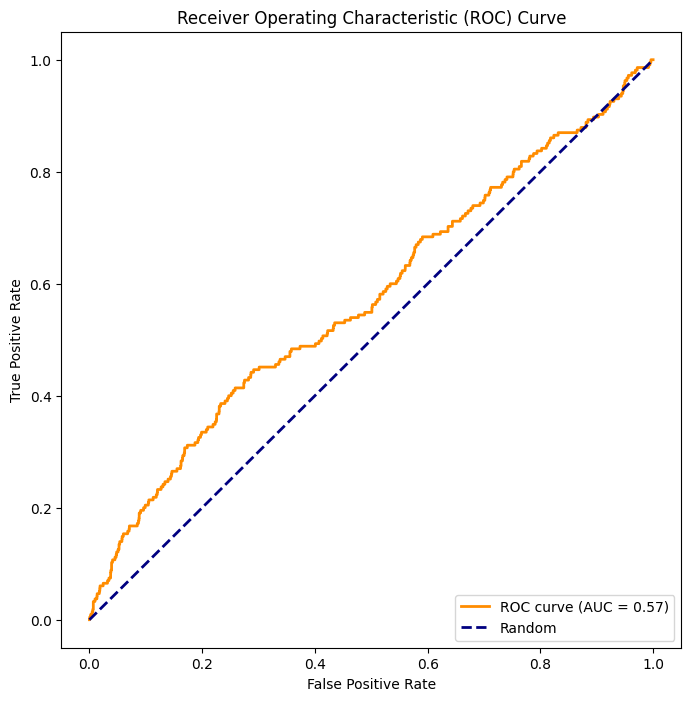

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# Predict probabilities on the test set
y_prob = modellr.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


##### **Testing**

In [ ]:
raw_test_set.rename(columns = {'M':'TotalMoney'}, inplace = True)
raw_test_set.rename(columns = {'R':'M_LastPurchase'}, inplace = True)
raw_test_set.rename(columns = {'F':'Freq'}, inplace = True)

test_df = raw_test_set.drop(columns = ['Seq#', 'ID#'], axis=1)

scalar = MinMaxScaler()
test_df = pd.DataFrame(scalar.fit_transform(test_df), columns = ['Gender','TotalMoney','M_LastPurchase','Freq','FirstPurch','ChildBks','YouthBks','CookBks','DoItYBks','RefBks','ArtBks','GeogBks','ItalCook','ItalAtlas','ItalArt','Florence'])

X_testJ = test_df.drop('Florence', axis=1)
y_testJ = test_df['Florence']

In [ ]:
y_predTest_LR = modellr.predict(X_testJ)

accuracyLR = accuracy_score(y_testJ, y_predTest_LR)
classification_rep = classification_report(y_testJ, y_predTest_LR)

# Display the results
print(f"Accuracy: {accuracyLR:.2f}")
print("Classification Report:\n", classification_rep)

Accuracy: 0.92
Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      1.00      0.96       732
         1.0       0.00      0.00      0.00        68

    accuracy                           0.92       800
   macro avg       0.46      0.50      0.48       800
weighted avg       0.84      0.92      0.87       800



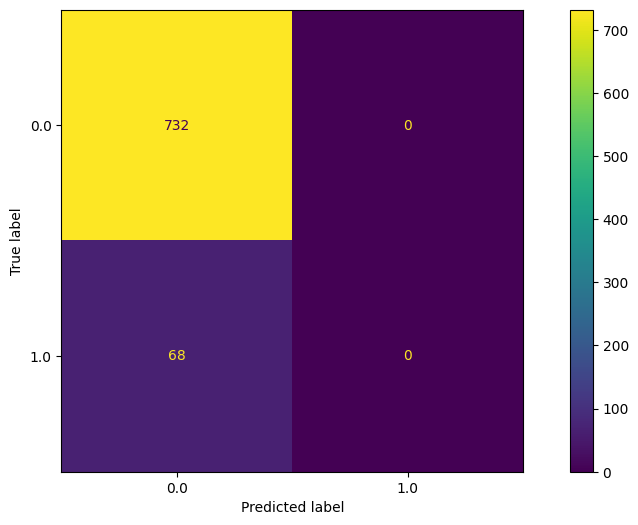

In [ ]:
ConfusionMatrixDisplay.from_estimator(modellr, X_testJ, y_testJ)

### Random Forest Classifier

Accuracy: 0.91
Confusion Matrix:
 [[2327   18]
 [ 214    1]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.99      0.95      2345
         1.0       0.05      0.00      0.01       215

    accuracy                           0.91      2560
   macro avg       0.48      0.50      0.48      2560
weighted avg       0.84      0.91      0.87      2560



<Axes: >

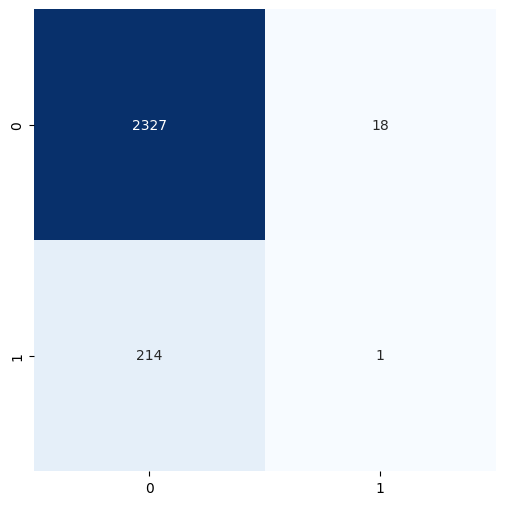

In [ ]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler


# Split the data into features (X) and target variable (y)
X = df.drop(['Florence'],axis=1)
y = df['Florence']

# Split the data into training and testing sets
X_train_RF, X_test_RF, y_train_RF, y_test_RF = train_test_split(X, y, test_size=0.8, random_state=1)

# Standardize features (optional but can be beneficial for Random Forest)
scaler = StandardScaler()
X_train_RF = scaler.fit_transform(X_train_RF)
X_test_RF = scaler.transform(X_test_RF)

# Create and train the Random Forest model
modelrf = RandomForestClassifier(random_state=1)
modelrf.fit(X_train_RF, y_train_RF)

# Make predictions on the test set
y_pred_RF = modelrf.predict(X_test_RF)

# Evaluate the model
accuracy = accuracy_score(y_test_RF, y_pred_RF)
conf_matrix = confusion_matrix(y_test_RF, y_pred_RF)
classification_rep = classification_report(y_test_RF, y_pred_RF)

# Display the results
print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_rep)

from sklearn.metrics import confusion_matrix
matrix_confusion = confusion_matrix(y_test_RF, y_pred_RF)
sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

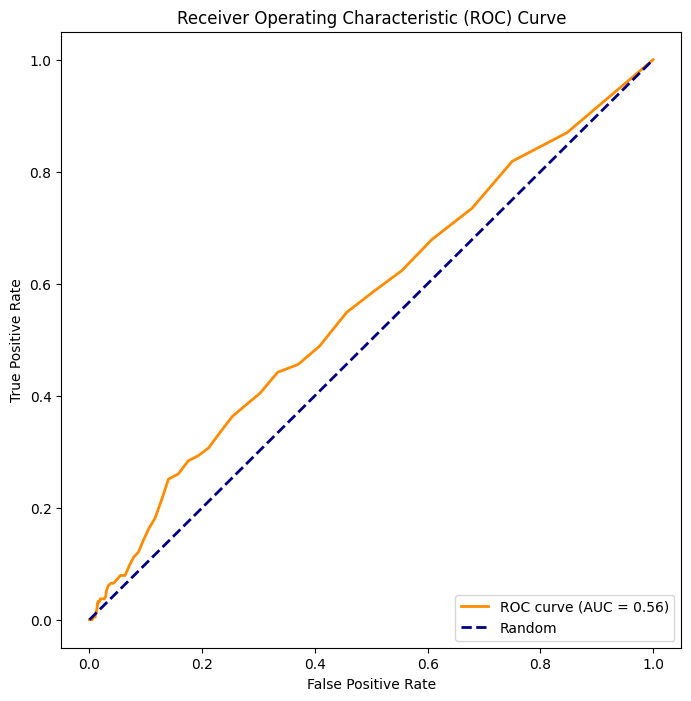

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# Predict probabilities on the test set
y_prob = model.predict_proba(X_test_RF)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


##### Testing

In [ ]:
y_predTest_RF = model.predict(X_testJ)

accuracyRF = accuracy_score(y_testJ, y_predTest_RF)
classification_rep = classification_report(y_testJ, y_predTest_RF)

# Display the results
print(f"Accuracy: {accuracyRF:.2f}")
print("Classification Report:\n", classification_rep)

Accuracy: 0.92
Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      1.00      0.96       732
         1.0       0.00      0.00      0.00        68

    accuracy                           0.92       800
   macro avg       0.46      0.50      0.48       800
weighted avg       0.84      0.92      0.87       800



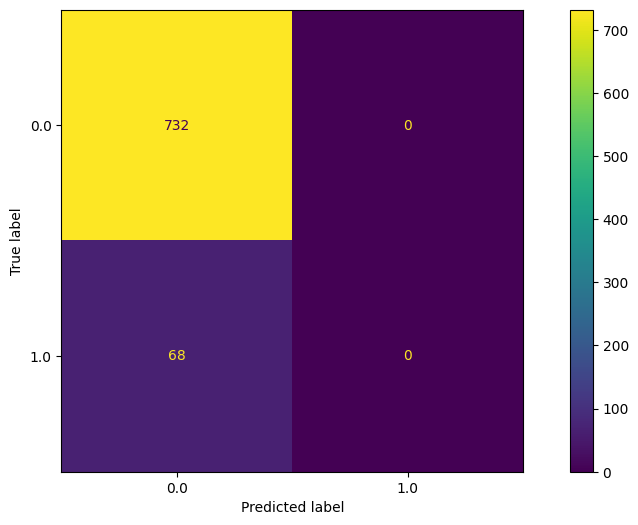

In [ ]:
ConfusionMatrixDisplay.from_estimator(model, X_testJ, y_testJ)

### Support Vector Classification (SVC)

##### Training

I chose SVC since thee data has 16 dimensions.  It is not clear if there is a clear margin of separation between the classes, but SVC is more effective in high dimensional spaces compared to other classifiers.  For the support vector classifier, I chose a radial basis function (rbf) kernel since I don't anticipate a linear relationship in such a high dimension space.

First the training dataset is separated into the attributes and label.  

In [ ]:
X_trainJ = df.drop('Florence', axis=1)
y_trainJ = df['Florence']

I wanted to first determine the best parameter value for "c".  A "c" value too high will lead to overfitting since it tightens up the margin of error. Next, the kernel selected with "poly".  Out of the other kernels (linear, rbf), the polynomial kernel had the highest f1 scores.

Text(0, 0.5, 'Accuracy')

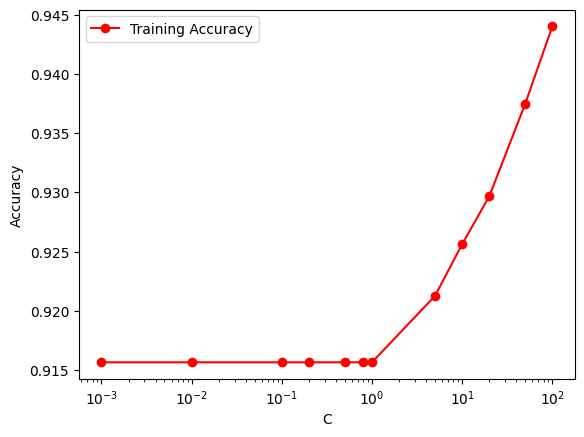

In [ ]:
from sklearn.svm import SVC

C = [0.001, 0.01, 0.1, 0.2, 0.5, 0.8, 1, 5, 10, 20, 50, 100]
SVCtrainAcc = []

for param in C:
    SVCclf = SVC(C=param,kernel='rbf', gamma='scale')
    SVCclf.fit(X_trainJ, y_trainJ)
    Y_predTrain = SVCclf.predict(X_trainJ)
    SVCtrainAcc.append(accuracy_score(y_trainJ, Y_predTrain))

plt.plot(C, SVCtrainAcc, 'ro-')
plt.legend(['Training Accuracy'])
plt.xlabel('C')
plt.xscale('log')
plt.ylabel('Accuracy')

In order to avoid overfitting, I decided to use a "c" of 1 since this is the highest c prior to an unexpected increase in accuracy.  I believe that using a higher value for "c" would lead to overfitting of the SVC model. I built another SVC model with a "c" of 1.  I set "probability" equal to true for future dimensionality reduction.

In [ ]:
SVCclf_1 = SVC(C=1, kernel='rbf', gamma='scale', probability=True)
SVCclf_1.fit(X_trainJ, y_trainJ)
Y_predTrain_1 = SVCclf_1.predict(X_trainJ)

accuracyl = accuracy_score(y_trainJ, Y_predTrain_1)
classification_rep = classification_report(y_trainJ, Y_predTrain_1)

# Display the results
print(f"Accuracy: {accuracyl:.2f}")
print("Classification Report:\n", classification_rep)

Accuracy: 0.92
Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      2930
         1.0       0.00      0.00      0.00       270

    accuracy                           0.92      3200
   macro avg       0.46      0.50      0.48      3200
weighted avg       0.84      0.92      0.88      3200



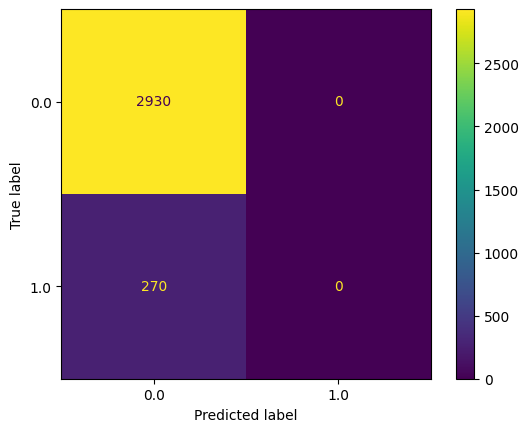

In [ ]:
ConfusionMatrixDisplay.from_estimator(SVCclf_1, X_trainJ, y_trainJ)

The "c" parameter is to be increased to 10 to see if the performance improves.  There is a risk the model will be overfit.

In [ ]:
SVCclf_L2 = SVC(C=10, kernel='rbf', probability=True)
SVCclf_L2.fit(X_trainJ, y_trainJ)
Y_predTrain_L = SVCclf_L2.predict(X_trainJ)

accuracyL2 = accuracy_score(y_trainJ, Y_predTrain_L)
classification_rep = classification_report(y_trainJ, Y_predTrain_L)

# Display the results
print(f"Accuracy: {accuracyL2:.2f}")
print("Classification Report:\n", classification_rep)

Accuracy: 0.93
Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      2930
         1.0       1.00      0.12      0.21       270

    accuracy                           0.93      3200
   macro avg       0.96      0.56      0.59      3200
weighted avg       0.93      0.93      0.90      3200



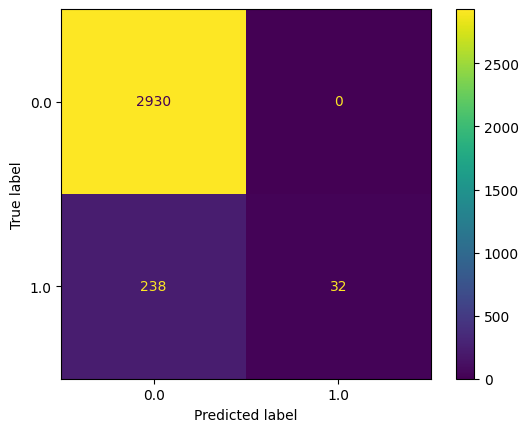

In [ ]:
ConfusionMatrixDisplay.from_estimator(SVCclf_L2, X_trainJ, y_trainJ)

There is an improvement in the f1 score at 0.21 for actual purchases of 'Florence'-not a significant improvement, but one nonetheless. I will utilize a "c" value of 1 in further steps to avoid overfitting.  To help improve the model performance,  I will next upsample the minority class (did not purchase 'Florence') using synthetic minority oversampling technique (SMOTE). This will fabricate new data from the minority class by creating new data between two instances of the minority class selected with KNN.  SMOTE will repeat the process until there are an equal number of instances in which individuals purchased and didn't purchase the 'Florence' book.  The thought process is that this will lead to better performance in selecting purchases.

In [ ]:
print("Before Upsampling: \n", Counter(y_trainJ))
sm = SMOTE()
X_res, y_res = sm.fit_resample(X_trainJ, y_trainJ)
print("After Upsampling: \n", Counter(y_res))

Before Upsampling: 
 Counter({0.0: 2930, 1.0: 270})
After Upsampling: 
 Counter({1.0: 2930, 0.0: 2930})


In [ ]:
SVCclf_u = SVC(C=1,kernel='rbf', gamma='scale', probability=True)
SVCclf_u.fit(X_res, y_res)
Y_predTrain_u = SVCclf_u.predict(X_res)

accuracyu = accuracy_score(y_res, Y_predTrain_u)
classification_rep = classification_report(y_res, Y_predTrain_u)

# Display the results
print(f"Accuracy: {accuracyu:.2f}")
print("Classification Report:\n", classification_rep)

Accuracy: 0.70
Classification Report:
               precision    recall  f1-score   support

         0.0       0.69      0.71      0.70      2930
         1.0       0.70      0.68      0.69      2930

    accuracy                           0.70      5860
   macro avg       0.70      0.70      0.70      5860
weighted avg       0.70      0.70      0.70      5860



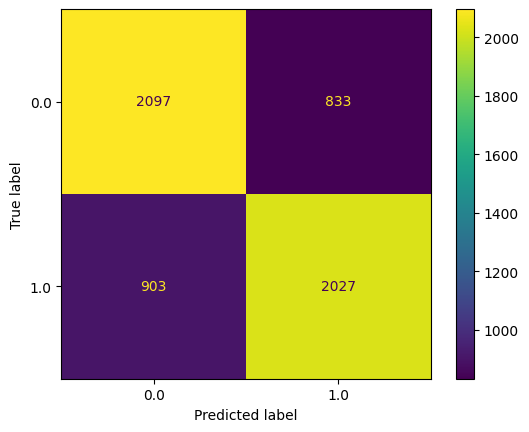

In [ ]:
ConfusionMatrixDisplay.from_estimator(SVCclf_u, X_res, y_res)

The upsampled data and model had a much better performance, with an f1 score of 0.74 and an accuracy of 0.73.  Next, cross validation will be performed to give us an idea if any overfitting is present in our model.

##### Cross Validation

In [ ]:
scores = cross_val_score(SVCclf_u,X_res, y_res, cv=10)

In [ ]:
print("10 k cross validation scores mean: ", scores.mean())
print("10 k cross validation scores max: ", scores.max())

THe 10 K cross validated model has a mean score is 0.70 and the max score is 0.74.  This indicates a low presence of over fitting as the scores are very close to our model accuracy and f1 score.  I will next move to testing our models utilizing the testing set. First, I will need to rename some columns as performed earlier on the training dataset, and remove the "Seq#' and 'ID#' columns from the testing dataset and normalize using MinMaxScalar().

##### Testing

In [ ]:
y_predTest_u = SVCclf_u.predict(X_testJ)

accuracytu = accuracy_score(y_testJ, y_predTest_u)
classification_rep = classification_report(y_testJ, y_predTest_u)

# Display the results
print(f"Accuracy: {accuracytu:.2f}")
print("Classification Report:\n", classification_rep)

Accuracy: 0.75
Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.79      0.85       732
         1.0       0.14      0.37      0.20        68

    accuracy                           0.75       800
   macro avg       0.53      0.58      0.53       800
weighted avg       0.86      0.75      0.80       800



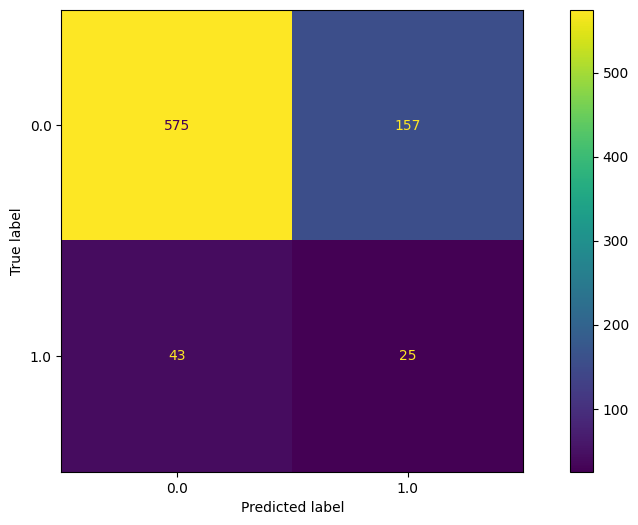

In [ ]:
ConfusionMatrixDisplay.from_estimator(SVCclf_u, X_testJ, y_testJ)

##### Area ROC

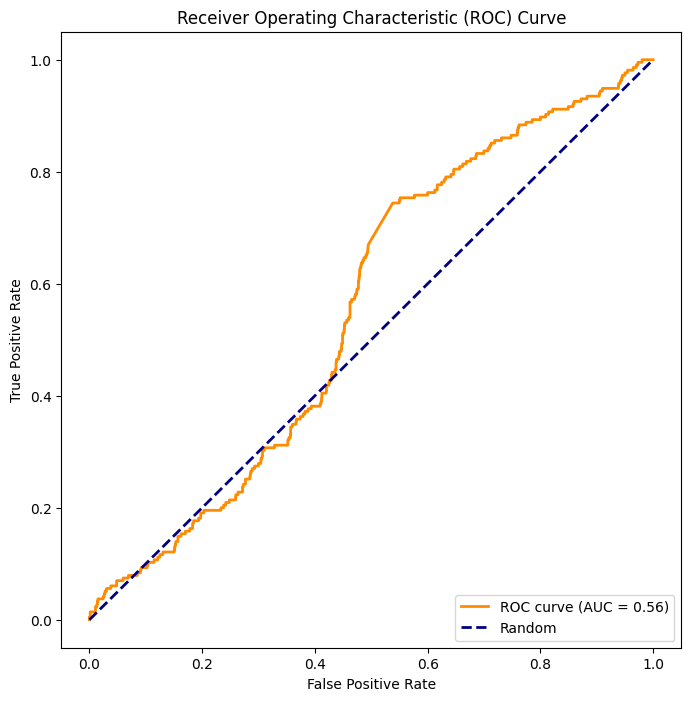

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# Predict probabilities on the test set
y_prob = SVCclf_u.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

##### Dimensionality Reduction and Retesting

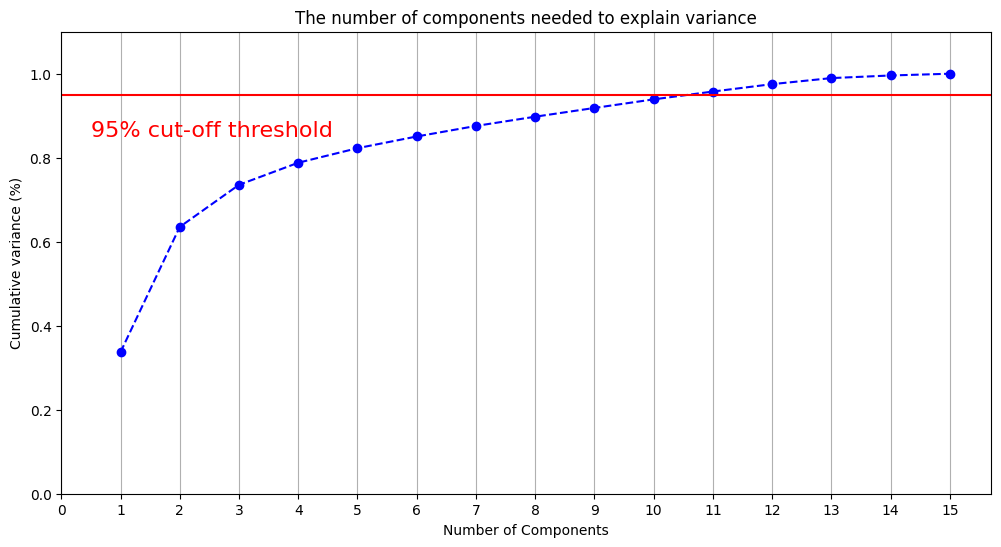

In [ ]:
pca = PCA().fit(X_trainJ)

plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 16, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 16, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [ ]:
pca = PCA(n_components=10)

In [ ]:
X_train_pca = pca.fit_transform(X_res)

In [ ]:
SVCclf_s = SVC(C=1,kernel='rbf', gamma='scale')
SVCclf_s.fit(X_train_pca, y_res)
y_predTrain_s = SVCclf_s.predict(X_train_pca)

accuracy_score(y_res, y_predTrain_s)
classification_rep = classification_report(y_res, y_predTrain_s)

# Display the results
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_rep)

Accuracy: 0.91
Classification Report:
               precision    recall  f1-score   support

         0.0       0.71      0.70      0.70      2930
         1.0       0.70      0.71      0.71      2930

    accuracy                           0.71      5860
   macro avg       0.71      0.71      0.71      5860
weighted avg       0.71      0.71      0.71      5860



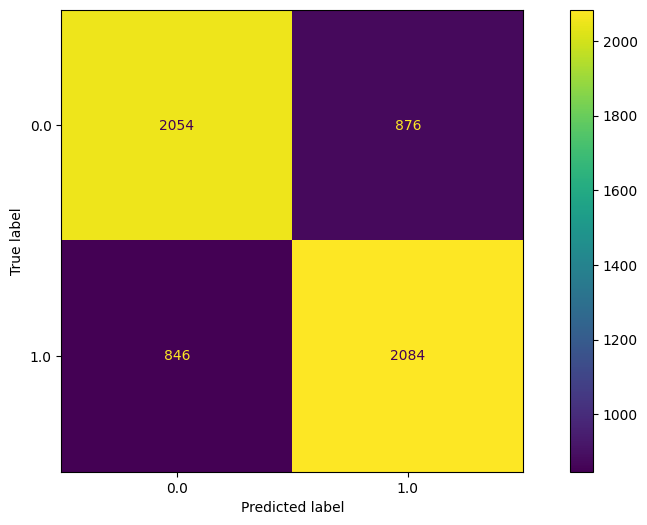

In [ ]:
ConfusionMatrixDisplay.from_estimator(SVCclf_s, X_train_pca, y_res)

In [ ]:
X_test_pca = pca.fit_transform(X_testJ)

In [ ]:
y_predTest_s = SVCclf_s.predict(X_test_pca)

accuracy_score(y_testJ, y_predTest_s)
classification_rep = classification_report(y_testJ, y_predTest_s)

# Display the results
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_rep)

Accuracy: 0.91
Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.66      0.77       732
         1.0       0.10      0.40      0.16        68

    accuracy                           0.64       800
   macro avg       0.51      0.53      0.46       800
weighted avg       0.85      0.64      0.72       800



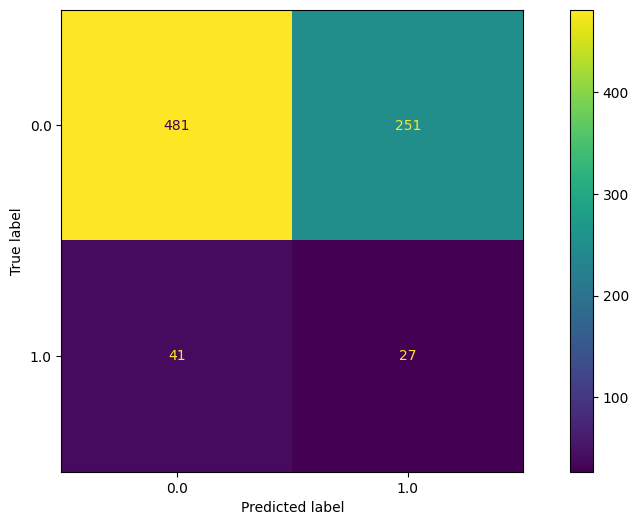

In [ ]:
ConfusionMatrixDisplay.from_estimator(SVCclf_s, X_test_pca, y_testJ)

Sources:

https://storm.cis.fordham.edu/gweiss/papers/dmin07-weiss.pdf

### Clustering: DBSCAN

In [ ]:
list = []
for i in range(1,500, 2):
  db = DBSCAN(eps=100, min_samples=i).fit(X_trainJ)
  db_labels = pd.DataFrame(db.labels_, columns = ["ClusterID"])
  db_df = pd.concat((X_trainJ, db_labels), axis=1)
  list.append(Counter(db_df.ClusterID)[0])

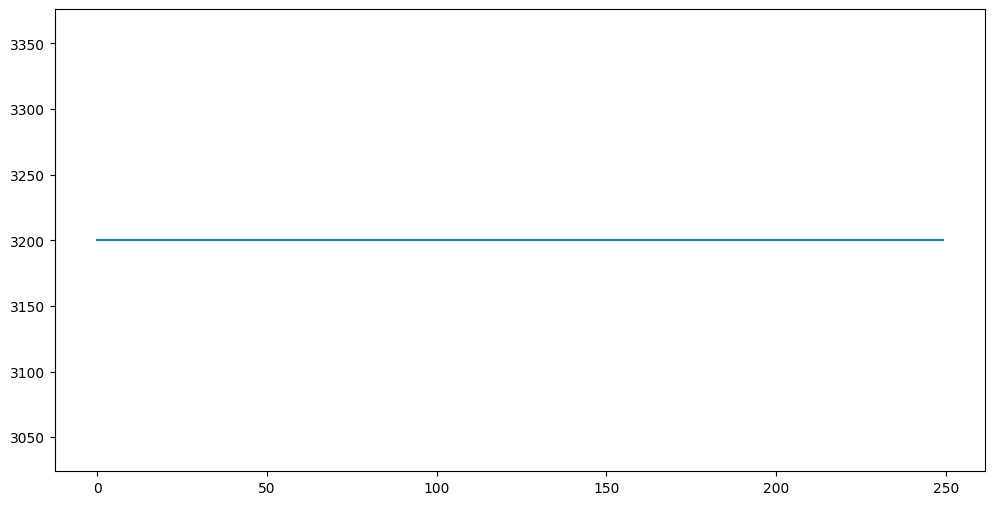

In [ ]:
plt.plot(list)

# SHAP

In [ ]:
!pip install shap
import shap

# load JS visualization code to notebook
shap.initjs()

# Create a SHAP explainer
explainer = shap.Explainer(model, X_train, feature_names=X.columns)
shap_values = explainer.shap_values(X_test)

# Calculate SHAP values for a subset of the data (e.g., X_test)
i = 4
shap.force_plot(explainer.expected_value, shap_values[i], features=X.iloc[i], feature_names=X.columns)



In [ ]:
# Plot summary plot for the first instance in the test set
shap.summary_plot(shap_values, features=X_test, feature_names=X.columns)

shap.summary_plot(shap_values, features=X_test, feature_names=X.columns, plot_type='bar')

# Sources

[1] A. Raj, “Everything about support vector classification - above and beyond,” Medium, https://towardsdatascience.com/everything-about-svm-classification-above-and-beyond-cc665bfd993e (accessed Dec. 3, 2023).

[2] “Learn,” scikit, https://scikit-learn.org/stable/index.html (accessed Dec. 3, 2023).

[3] “PCA - how to choose the number of components?,” Bartosz Mikulski - AI consultant, https://mikulskibartosz.name/pca-how-to-choose-the-number-of-components (accessed Dec. 3, 2023).

[4] “Probability distribution,” Wikipedia, https://en.wikipedia.org/wiki/Probability_distribution (accessed Dec. 3, 2023).

[5] “Welcome to the shap documentation,” Welcome to the SHAP documentation - SHAP latest documentation, https://shap.readthedocs.io/en/latest/ (accessed Dec. 3, 2023).